# Analysis of CP-DINO 1640 + pS6 embeddings and Features

In [1]:
%load_ext autoreload
%autoreload 2

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cp_posh.analysis import similarity, aggregate, plotting

In [1]:
#!aws s3 cp s3://insitro-research-2023-cellpaint-posh/normalized_embeddings/cellstats_features_druggable_genome_1642.pq ./datasets/normalized_embeddings/

In [8]:
sgRNA_aggregate_embeddings = pd.read_parquet("./datasets/aggregate_sgRNA_embeddings/cpdino_1640pS6_embeddings_druggable_genome_1640pS6.pq")

## Measuring the similarities of gRNAs targeting the same genes
#### gRNA similarities can be shown either as boxplots or as scatterplots showing the distributions of individual gRNAs for each gene

/home/ubuntu/software/cp-posh/cp_posh/analysis/similarity.py:76: RuntimeWarning: divide by zero encountered in scalar divide
  gRNAscore = gRNAscore / (len(gRNAset) - 1)
/home/ubuntu/software/cp-posh/cp_posh/analysis/similarity.py:76: RuntimeWarning: invalid value encountered in scalar divide
  gRNAscore = gRNAscore / (len(gRNAset) - 1)
/home/ubuntu/miniconda3/envs/insitro/lib/python3.11/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in scalar subtract
  diff_b_a = subtract(b, a)
/home/ubuntu/miniconda3/envs/insitro/lib/python3.11/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/ubuntu/miniconda3/envs/insitro/lib/python3.11/site-packages/matplotlib/cbook.py:1267: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/home/ubuntu/miniconda3/envs/insitro/lib/python3.11/site-packages/matplotlib/cbook.py:1274: RuntimeWarning: invalid val

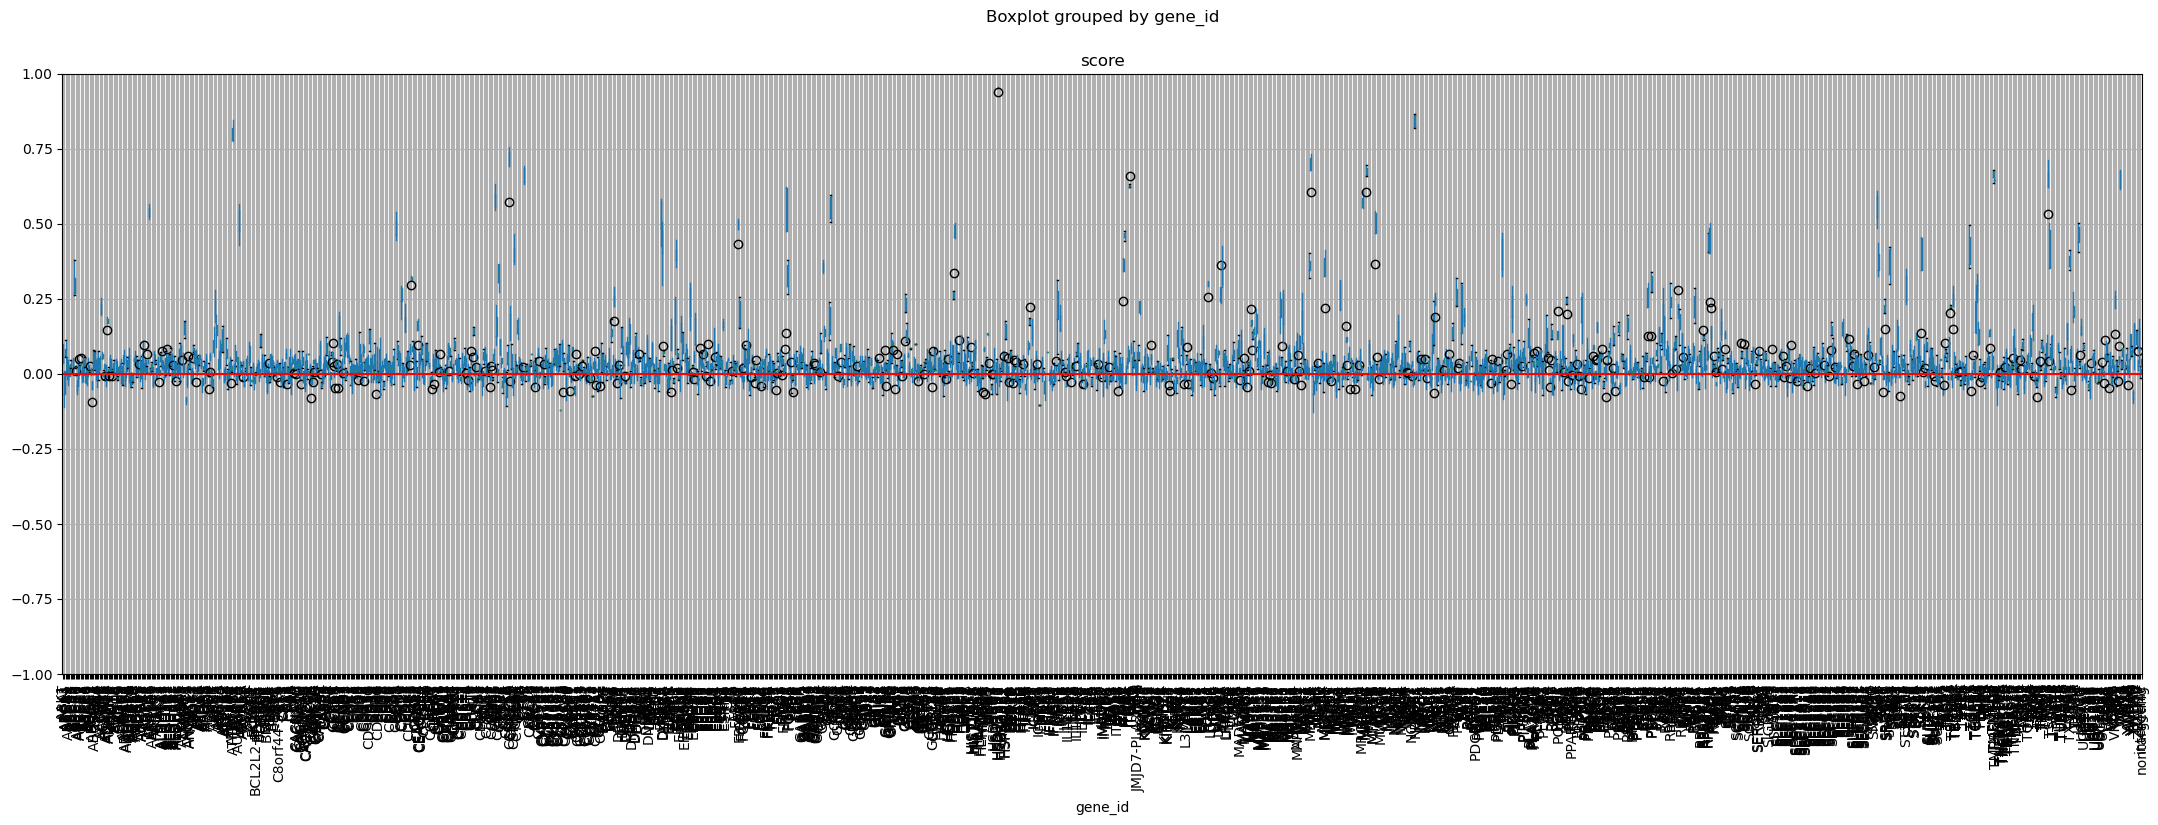

In [10]:
gRNAscores = similarity.get_gRNA_scores(sgRNA_aggregate_embeddings)
gRNAscores['score'] = gRNAscores['score'].apply(pd.to_numeric)

## Median Aggregation to the gene level

In [12]:
gene_aggregate_embeddings = aggregate.aggregate_embeddings_by_gene(embeddings = sgRNA_aggregate_embeddings, method = 'median')

## Calculate cosine similarity of aggregated genes and plot as a heatmap

In [14]:
cosine_similarity = similarity.get_embedding_cosine_similarity(gene_aggregate_embeddings)

## Visualize UMAP of gene aggregate embeddings

/home/ubuntu/miniconda3/envs/insitro/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/ubuntu/software/cp-posh/cp_posh/analysis/plotting.py:279: RuntimeWarning: invalid value encountered in multiply
  size = np.maximum(np.array(df.score.values) * 0, dot_size_min)  # type: ignore


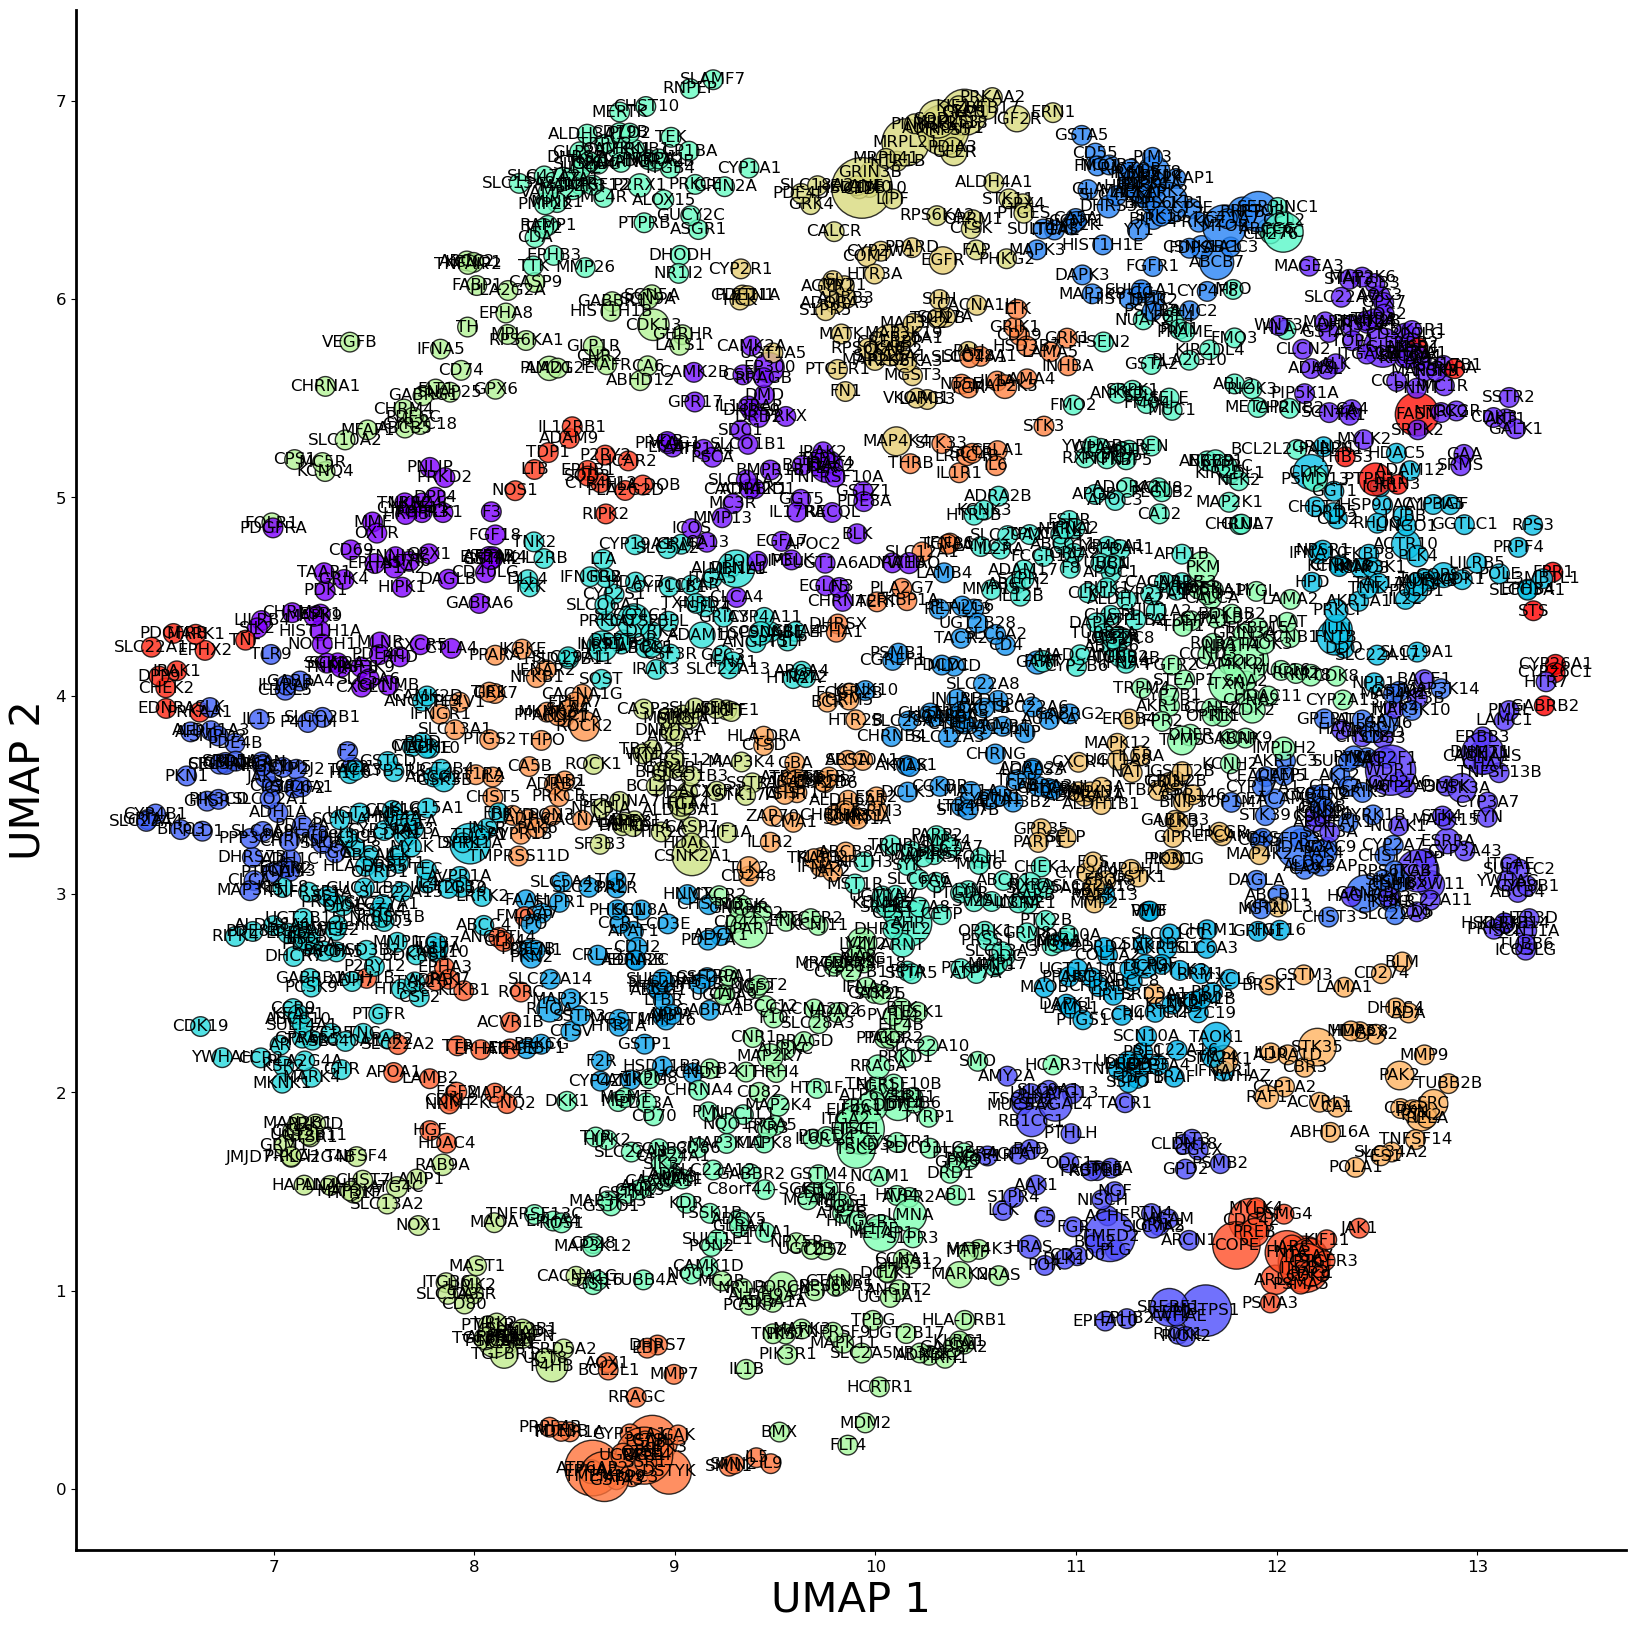

UMAP(angular_rp_forest=True, metric='cosine', n_jobs=1, n_neighbors=5, random_state=2, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [ ]:
select_genes = list(gene_aggregate_embeddings.index.get_level_values('gene_id'))

gRNAscores_simple = pd.DataFrame(index = gRNAscores.index.get_level_values('gene_id'), data={'score':gRNAscores.score.values})
gRNAscores_simple = gRNAscores_simple.groupby('gene_id').mean()
worst_score = gRNAscores.replace([np.inf, -np.inf], np.nan).dropna(axis=1).min() # some genes only have one gRNA, leading to no ability to calculate a gRNA score.  These are set to the lowest score of the real dataset
gRNAscores_nonan = gRNAscores.replace([np.inf, -np.inf], np.nan).replace(np.nan,worst_score)

plotting.compute_plot_umap(
    gene_embeddings = gene_aggregate_embeddings,
    selected_genes = select_genes,
    within_gene_gRNA_similarity_scores = gRNAscores_simple,
    neighbors = 5,
    leiden_resolution = 1,
    max_community_size = 50,
    clusters = None,
    adjust_texts=False,
    dot_size_min = 200,
    dot_size_max = 2000,
    font_size = 12,
    random_state = 2,
)